# PDE-FIND for identifying Navier-Stokes

Samuel Rudy, 2016

This notebook demonstrates PDE-FIND for the vorticity equation given a simulation of fluid flowing around a cylinder.
\begin{align*}
\omega_t &= \frac{1}{Re}\nabla^2 \omega - (V \cdot \nabla)\omega\\
V &= (v,u)\\
Re &= 100
\end{align*}
The x and y components of the velocity field are given as forcing terms to the PDE.  That is, they appear in $\Theta$, but are not differentiated.

In [1]:
%pylab inline
pylab.rcParams['figure.figsize'] = (12, 8)
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import sys; sys.path.append('../')
from PDE_FIND import *
import scipy.io as sio
import itertools

Populating the interactive namespace from numpy and matplotlib


Load in the data.

In [2]:
# Load data
steps = 151
n = 449
m = 199
U = np.load('../Datasets/course_timestep_cylinder/Cylinder_U.npy')
V = np.load('../Datasets/course_timestep_cylinder/Cylinder_V.npy')
W = np.load('../Datasets/course_timestep_cylinder/Cylinder_W.npy')

dt = 0.2
dx = 0.02
dy = 0.02

# Cut out the portion of the data before the cylinder
xmin = 100
xmax = 425
ymin = 15
ymax = 185

W = W[xmin:xmax,ymin:ymax,:]
U = U[xmin:xmax,ymin:ymax,:]
V = V[xmin:xmax,ymin:ymax,:]
n,m,steps = W.shape

Here we take the SVD of the data and reconstruct either with a reduced basis or everything.  It isn't necesarry but is interesting to show that we can still derive the correct PDE with the first 50 modes (maybe less). 

In [3]:
W = W.reshape(n*m,steps)
U = U.reshape(n*m,steps)
V = V.reshape(n*m,steps)

In [4]:
uw,sigmaw,vw = svd(W, full_matrices=False); vw = vw.T
uu,sigmau,vu = svd(U, full_matrices=False); vu = vu.T
uv,sigmav,vv = svd(V, full_matrices=False); vv = vv.T

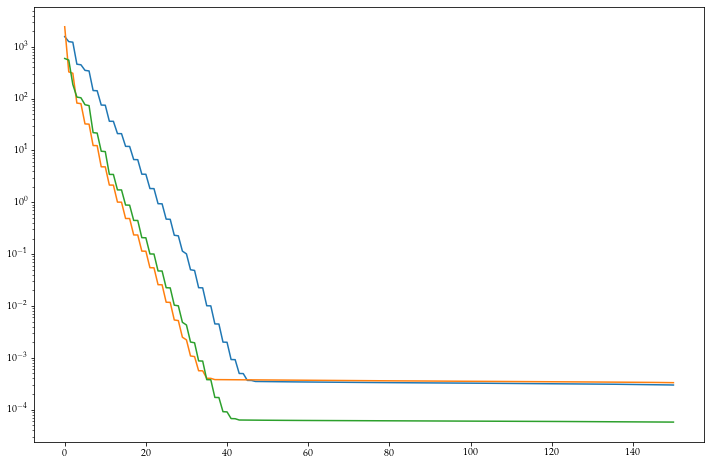

In [5]:
semilogy(sigmaw)
semilogy(sigmau)
semilogy(sigmav)

In [6]:
# Use this code to identify the PDE from reduced basis
# dim = 50
# Wn = uw[:,0:dim].dot(np.diag(sigmaw[0:dim]).dot(vw[:,0:dim].T)).reshape(n,m,steps)
# Un = uu[:,0:dim].dot(np.diag(sigmau[0:dim]).dot(vu[:,0:dim].T)).reshape(n,m,steps)
# Vn = uv[:,0:dim].dot(np.diag(sigmav[0:dim]).dot(vv[:,0:dim].T)).reshape(n,m,steps)

# Or this code to take the full solution
Wn = W.reshape(n,m,steps)
Un = U.reshape(n,m,steps)
Vn = V.reshape(n,m,steps)

## Sample data points

Now randomly sample some points to use.  See figure 1, panel 2a-2c for visual description of what we're doing here.  5000 spatial points are samples and 60 timepoints are viewed at each one.  Note that we still need nearby points to take derivatives.

In [7]:
# Sample a collection of data points, stay away from edges so I can just use centered finite differences.
np.random.seed(0)

num_xy = 5000
num_t = 60
num_points = num_xy * num_t
boundary = 5
boundary_x = 10
points = {}
count = 0

for p in range(num_xy):
    x = np.random.choice(np.arange(boundary_x,n-boundary_x),1)[0]
    y = np.random.choice(np.arange(boundary,m-boundary),1)[0]
    for t in range(num_t):
        points[count] = [x,y,2*t+12]
        count = count + 1

## Construct $\Theta (U)$ and compute $U_t$

Take derivatives and assemble into $\Theta(\omega, u ,v)$

In [8]:
# Take up to second order derivatives.
w = np.zeros((num_points,1))
u = np.zeros((num_points,1))
v = np.zeros((num_points,1))
wt = np.zeros((num_points,1))
wx = np.zeros((num_points,1))
wy = np.zeros((num_points,1))
wxx = np.zeros((num_points,1))
wxy = np.zeros((num_points,1))
wyy = np.zeros((num_points,1))

N = 2*boundary-1  # odd number of points to use in fitting
Nx = 2*boundary_x-1  # odd number of points to use in fitting
deg = 5 # degree of polynomial to use

for p in points.keys():
    
    [x,y,t] = points[p]
    w[p] = Wn[x,y,t]
    u[p] = Un[x,y,t]
    v[p] = Vn[x,y,t]
    
    wt[p] = PolyDiffPoint(Wn[x,y,t-(N-1)//2:t+(N+1)//2], np.arange(N)*dt, deg, 1)[0]
    
    x_diff = PolyDiffPoint(Wn[x-(Nx-1)//2:x+(Nx+1)//2,y,t], np.arange(Nx)*dx, deg, 2)
    y_diff = PolyDiffPoint(Wn[x,y-(N-1)//2:y+(N+1)//2,t], np.arange(N)*dy, deg, 2)
    wx[p] = x_diff[0]
    wy[p] = y_diff[0]
    
    x_diff_yp = PolyDiffPoint(Wn[x-(Nx-1)//2:x+(Nx+1)//2,y+1,t], np.arange(Nx)*dx, deg, 2)
    x_diff_ym = PolyDiffPoint(Wn[x-(Nx-1)//2:x+(Nx+1)//2,y-1,t], np.arange(Nx)*dx, deg, 2)
    
    wxx[p] = x_diff[1]
    wxy[p] = (x_diff_yp[0]-x_diff_ym[0])/(2*dy)
    wyy[p] = y_diff[1]

In [9]:
# Form Theta using up to quadratic polynomials in all variables.
X_data = np.hstack([w,u,v])
X_ders = np.hstack([np.ones((num_points,1)), wx, wy, wxx, wxy, wyy])
X_ders_descr = ['','w_{x}', 'w_{y}','w_{xx}','w_{xy}','w_{yy}']
X, description = build_Theta(X_data, X_ders, X_ders_descr, 2, data_description = ['w','u','v'])
print('Candidate terms for PDE')
['1']+description[1:]

Candidate terms for PDE


['1',
 'w_{x}',
 'w_{y}',
 'w_{xx}',
 'w_{xy}',
 'w_{yy}',
 'v',
 'u',
 'w',
 'v^2',
 'uv',
 'u^2',
 'wv',
 'wu',
 'w^2',
 'vw_{x}',
 'uw_{x}',
 'ww_{x}',
 'v^2w_{x}',
 'uvw_{x}',
 'u^2w_{x}',
 'wvw_{x}',
 'wuw_{x}',
 'w^2w_{x}',
 'vw_{y}',
 'uw_{y}',
 'ww_{y}',
 'v^2w_{y}',
 'uvw_{y}',
 'u^2w_{y}',
 'wvw_{y}',
 'wuw_{y}',
 'w^2w_{y}',
 'vw_{xx}',
 'uw_{xx}',
 'ww_{xx}',
 'v^2w_{xx}',
 'uvw_{xx}',
 'u^2w_{xx}',
 'wvw_{xx}',
 'wuw_{xx}',
 'w^2w_{xx}',
 'vw_{xy}',
 'uw_{xy}',
 'ww_{xy}',
 'v^2w_{xy}',
 'uvw_{xy}',
 'u^2w_{xy}',
 'wvw_{xy}',
 'wuw_{xy}',
 'w^2w_{xy}',
 'vw_{yy}',
 'uw_{yy}',
 'ww_{yy}',
 'v^2w_{yy}',
 'uvw_{yy}',
 'u^2w_{yy}',
 'wvw_{yy}',
 'wuw_{yy}',
 'w^2w_{yy}']

## Solve for $\xi$

TrainSTRidge splits the data up into 80% for training and 20% for validation.  It searches over various tolerances in the STRidge algorithm and finds the one with the best performance on the validation set, including an $\ell^0$ penalty for $\xi$ in the loss function.

In [10]:
lam = 10**-5
d_tol = 5
c = TrainSTRidge(X,wt,lam,d_tol)
print_pde(c, description, ut = 'w_t')

w_t = (0.009872 +0.000000i)w_{xx}
    + (0.009903 +0.000000i)w_{yy}
    + (-0.990355 +0.000000i)uw_{x}
    + (-0.986597 +0.000000i)vw_{y}
   


In [11]:
err = abs(np.array([(0.009884-0.01)*100/0.01, (0.009902-0.01)*100/0.01, (-0.990371+1)*100, (-0.986629+1)*100]))
print("Error using PDE-FIND to identify Navier-Stokes:\n")
print("Mean parameter error:", np.mean(err), '%')
print("Standard deviation of parameter error:", np.std(err), '%')

Error using PDE-FIND to identify Navier-Stokes:

Mean parameter error: 1.110000000000002 %
Standard deviation of parameter error: 0.15216177246601606 %
